## Shopping Cart Abandonment Prediction
### Data Analysis

In [1]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Click sequence for all data points
sequence_length = 30

In [3]:
with open('data/X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('data/y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('data/X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('data/y_test.npy', 'rb') as f:
    y_test = np.load(f)

### Buy vs. Abandon Analysis
We count the total number of sequences that end in a buy event, and the number that end in a abandon event. Then calculate the percentages of each.

In [4]:
total = len(y_train)
buys = (y_train == 1).sum()
abandons = (y_train == 0).sum()
print(f"Total click sequences: {total}")
print(f"Abandons: {abandons}")
print(f"Buys: {buys}")
print(f"Percentage Abandons: {abandons / total}")
print(f"Percentage Buys: {buys / total}")

Total click sequences: 7381855
Abandons: 6979243
Buys: 402612
Percentage Abandons: 0.9454592375493693
Percentage Buys: 0.05454076245063064


It's worth noting that we could get 0.9455 accuracy by simply predicting "abandon" for all inputs, but AUC is poor. Below we see the metrics for this "naive" classifier.

AUC: 0.5
              precision    recall  f1-score   support

           0     0.9455    1.0000    0.9720   1744811
           1     0.0000    0.0000    0.0000    100653

    accuracy                         0.9455   1845464
   macro avg     0.4727    0.5000    0.4860   1845464
weighted avg     0.8939    0.9455    0.9190   1845464



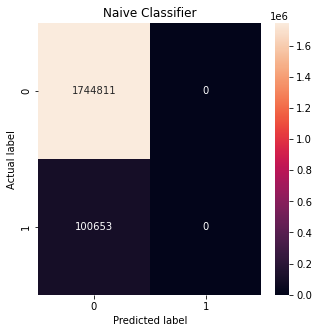

In [5]:
# Naive classifier: predict zero for all samples
y_pred = np.zeros(len(y_test), dtype=int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(f"AUC: {auc(fpr, tpr)}")

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Naive Classifier")
plt.show()

### Session Length Analysis
We count the number of sessions for each length from 1 to 30 in the training set and provide some histograms for visualization.

Total: 7381855
Min session length: 1
Max session length: 30


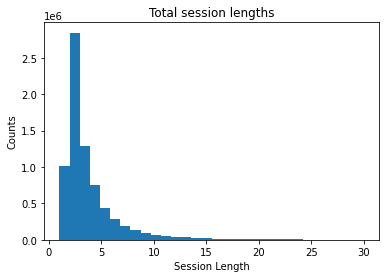

In [6]:
# Total session lengths
sess_lens = []
for i in range(X_train.shape[0]):
    sess_lens.append(np.count_nonzero(X_train[i,:,0]))

sess_lens = np.array(sess_lens)
print(f"Total: {len(sess_lens)}")
print(f"Min session length: {np.min(sess_lens)}")
print(f"Max session length: {np.max(sess_lens)}")

plt.hist(sess_lens, bins=sequence_length)
plt.ylabel('Counts')
plt.xlabel('Session Length');
plt.title('Total session lengths')
plt.show()

Total: 402612
Min session length: 1
Max session length: 30


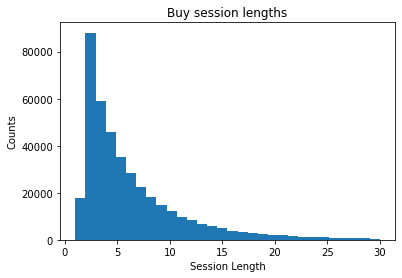

In [7]:
# Buy session lengths
buy_sess_lens = []
for i in range(X_train.shape[0]):
    if (y_train[i] == 1):
        buy_sess_lens.append(np.count_nonzero(X_train[i,:,0]))

buy_sess_lens = np.array(buy_sess_lens)
buy_sess_counts = np.bincount(buy_sess_lens, minlength=sequence_length)
print(f"Total: {len(buy_sess_lens)}")
print(f"Min session length: {np.min(buy_sess_lens)}")
print(f"Max session length: {np.max(buy_sess_lens)}")

plt.hist(buy_sess_lens, bins=sequence_length)
plt.ylabel('Counts')
plt.xlabel('Session Length');
plt.title('Buy session lengths')
plt.show()

Total: 6979243
Min session length: 1
Max session length: 30


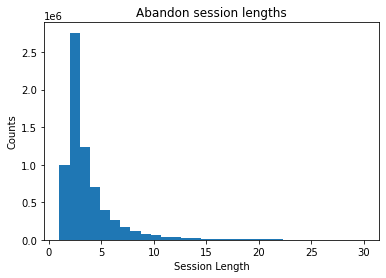

In [8]:
# Abandon session lengths
abandon_sess_lens = []
for i in range(X_train.shape[0]):
    if (y_train[i] == 0):
        abandon_sess_lens.append(np.count_nonzero(X_train[i,:,0]))

abandon_sess_lens = np.array(abandon_sess_lens)
abandon_sess_counts = np.bincount(abandon_sess_lens, minlength=sequence_length)
print(f"Total: {len(abandon_sess_lens)}")
print(f"Min session length: {np.min(abandon_sess_lens)}")
print(f"Max session length: {np.max(abandon_sess_lens)}")

plt.hist(abandon_sess_lens, bins=30)
plt.ylabel('Counts')
plt.xlabel('Session Length');
plt.title('Abandon session lengths')
plt.show()

By examining the histograms, we see that the distribution of "buy" session lengths is less skewed to the left. We might hypothesize that longer sequence lengths are more indicative of "buy" sessions. We can create a simple classifier that classifies any session above a certain length as "buy":

AUC: 0.5716573023528493
              precision    recall  f1-score   support

           0     0.9532    0.9616    0.9574   1744811
           1     0.2143    0.1818    0.1967    100653

    accuracy                         0.9190   1845464
   macro avg     0.5838    0.5717    0.5770   1845464
weighted avg     0.9129    0.9190    0.9159   1845464



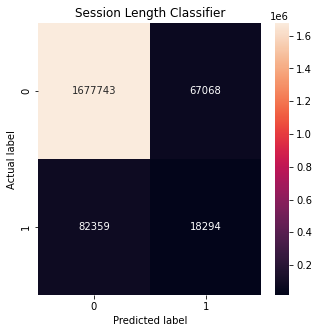

In [9]:
def sess_len_classify(sess_len):
    return sess_len >= 10

y_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    y_pred[i] = sess_len_classify(np.count_nonzero(X_test[i,:,0]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(f"AUC: {auc(fpr, tpr)}")

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Session Length Classifier")
plt.show()

We see an improvement in AUC, but accuracy is down. Alternatively, we can scale the session length counts for both abandons and buys, and compare those values to make our prediction:

In [10]:
def scale(array):
    minimum, maximum = np.min(array), np.max(array)
    m = 1 / (maximum - minimum)
    return m * array - m * minimum

scaled_buy_counts = scale(buy_sess_counts)
scaled_abandon_counts = scale(abandon_sess_counts)

AUC: 0.6374513482934421
              precision    recall  f1-score   support

           0     0.9726    0.5375    0.6924   1744811
           1     0.0842    0.7374    0.1512    100653

    accuracy                         0.5484   1845464
   macro avg     0.5284    0.6375    0.4218   1845464
weighted avg     0.9241    0.5484    0.6628   1845464



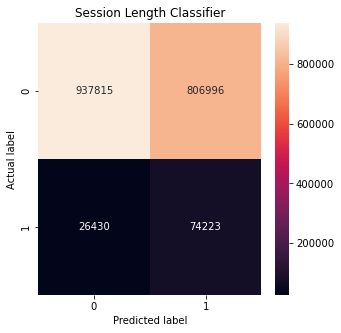

In [11]:
def sess_len_classify(sess_len):
    return scaled_buy_counts[sess_len] > scaled_abandon_counts[sess_len]

y_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    y_pred[i] = sess_len_classify(np.count_nonzero(X_test[i,:,0]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(f"AUC: {auc(fpr, tpr)}")

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Session Length Classifier")
plt.show()

Here, AUC is improved further, but accuracy is greatly reduced. We conclude that session length may have some value as a predicting feature, but our simple models are unable to use it effectively. A good model should increase both AUC and accuracy.

### Item analysis
We count the frequencies of each item in the training data.

In [12]:
# Most frequent items in all sessions
items = X_train[:,:,1].reshape(-1)
items = items[items != 0]
counts = np.bincount(items)
num_items = len(counts)
ind = np.argsort(counts)[-10:][::-1]
print("Top 10 frequent items (total)")
print("Item\tCount")
print("----\t----")
for i, c in zip(ind, counts[ind]):
    print(f"{i}\t{c}")

Top 10 frequent items (total)
Item	Count
----	----
33037	113812
46301	100151
31948	89285
47530	61838
23836	54388
46302	52739
8888	47996
26468	47920
40213	47616
9332	44215


In [13]:
# Most frequent items in buy sessions
train_indices = y_train == 1
items = X_train[train_indices,:,1].reshape(-1)
items = items[items != 0]
buy_item_counts = np.bincount(items, minlength=num_items)
ind = np.argsort(buy_item_counts)[-10:][::-1]
print("Top 10 frequent items (buy)")
print("Item\tCount")
print("----\t----")
for i, c in zip(ind, buy_item_counts[ind]):
    print(f"{i}\t{c}")

Top 10 frequent items (buy)
Item	Count
----	----
33037	24996
31948	13543
47530	8506
26467	8051
26468	7633
23836	7558
9320	6959
30737	6934
46301	6793
32986	6060


In [14]:
# Most frequent items in abandon sessions
train_indices = y_train == 0
items = X_train[train_indices,:,1].reshape(-1)
items = items[items != 0]
abandon_item_counts = np.bincount(items, minlength=num_items)
ind = np.argsort(abandon_item_counts)[-10:][::-1]
print("Top 10 frequent items (abandon)")
print("Item\tCount")
print("----\t----")
for i, c in zip(ind, abandon_item_counts[ind]):
    print(f"{i}\t{c}")

Top 10 frequent items (abandon)
Item	Count
----	----
46301	93358
33037	88816
31948	75742
47530	53332
46302	48348
23836	46830
40213	43624
8888	43405
26468	40287
9332	39829


We test the effectiveness of item frequency as a predictor. A simple classifier can sum up the "buy" frequency counts and the "abandon" frequency counts from the training set for each item in a sequence. The label with the larger sum is used as the prediction:

AUC: 0.5000095539436856
              precision    recall  f1-score   support

           0     0.9455    1.0000    0.9720   1744811
           1     0.1000    0.0000    0.0001    100653

    accuracy                         0.9454   1845464
   macro avg     0.5227    0.5000    0.4860   1845464
weighted avg     0.8993    0.9454    0.9189   1845464



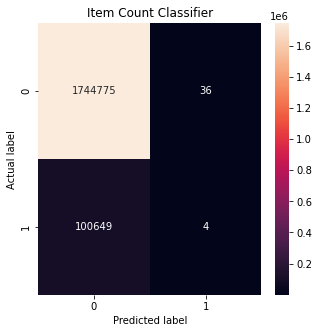

In [15]:
def count_classify(items):
    sum_buy = 0
    sum_abandon = 0
    for item in items:
        sum_buy += buy_item_counts[item]
        sum_abandon += abandon_item_counts[item]
    if sum_buy > sum_abandon:
        return 1
    else:
        return 0

y_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    y_pred[i] = count_classify(X_test[i,:,1])

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(f"AUC: {auc(fpr, tpr)}")

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Item Count Classifier")
plt.show()

We do not see improvements of AUC and accuracy over our naive predictor. We conclude that item counts alone are a poor predictor for this task. But a more advanced model might be capable of extracting knowledge about the the items in a session to improve the metrics.